In [1]:
%matplotlib inline
import numpy as np
import math, random
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

class Gaussian2D:
    def __init__(self,sigma_x = 1.0, sigma_y = 1.0, cov_xy = 0.0,mu_x = 0.0, mu_y = 0.0):
        self.cov = np.array([[sigma_x,cov_xy],[cov_xy,sigma_y]])
        self.mean = np.array([mu_x,mu_y]).T
        
    def shift(self,delta,angle):
        ca = math.cos(angle)
        sa = math.sin(angle)
        rot = np.array([[ca,sa],[-sa,ca]])
        
        self.cov = rot.dot(self.cov).dot(rot.T)
        self.mean = self.mean + delta
        
    def value(self, pos):
        delta = pos - self.mean
        numerator = math.exp(-0.5 * (delta.T).dot(np.linalg.inv(self.cov)).dot(delta))
        denominator = 2 * math.pi * math.sqrt(np.linalg.det(self.cov))
        #print(numerator / denominator)
        return numerator / denominator
    
    def ellipse(self):
        eigen = np.linalg.eig(self.cov)
        
        v1 = eigen[0][0] * eigen[1][0]
        v2 = eigen[0][1] * eigen[1][1]
        v1_direction = math.atan2(v1[1],v1[0])
        
        e = Ellipse(self.mean,width=np.linalg.norm(v1),height=np.linalg.norm(v2),angle=v1_direction/3.14*180)
        e.set_alpha(0.2)
        
        return e

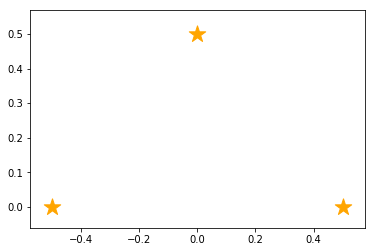

In [2]:
class Landmarks:
    def __init__(self,array):
        self.positions = array
    
    def draw(self):
        xs = [ e[0] for e in self.positions]
        ys = [ e[1] for e in self.positions]
        plt.scatter(xs,ys,s=300,marker="*",label="landmarks",color="orange")
        
class Observation:
    def __init__(self,robot_pos, landmark,lid):
        self.sensor_max_range = 1.0
        self.sensor_min_range = 0.1
        self.sensor_max_angle = math.pi / 2
        self.sensor_min_angle = - math.pi /2 
        
        self.lid = None
        rx,ry,rt = robot_pos[0],robot_pos[1],robot_pos[2]
        lx,ly = landmark[0],landmark[1]
        
        distance = math.sqrt((rx-lx)**2 + (ry-ly)**2)
        if distance > self.sensor_max_range or distance < self.sensor_min_range:
            return
        
        direction = math.atan2(ly-ry, lx-rx) - rt
        if direction > math.pi:    direction -= 2*math.pi
        if direction < -math.pi:   direction += 2*math.pi     
            
        if direction > self.sensor_max_angle or direction < self.sensor_min_angle:
            return
        
        distance = random.gauss(distance,distance * 0.03)   #3% gauss noise
        direction = random.gauss(direction,math.pi * 3 /180)   #3deg gauss noise
     
        x = rx + distance * math.cos(rt + direction)
        y = ry + distance * math.sin(rt + direction)
        
        self.mean = np.array([x,y]).T
        
        self.error_ellipse = Gaussian2D(sigma_x = distance * 0.03, sigma_y = distance * math.sin(math.pi * 3 /180 ) , cov_xy = 0.0)
        self.error_ellipse.shift(self.mean, rt + direction)
        
        self.distance, self.direction = distance, direction
        
        self.lid = lid
        
    def likelihood(self,robot_pos):
        rx, ry, rt = robot_pos[0], robot_pos[1], robot_pos[2]
        lx = rx + self.distance * math.cos(rt + self.direction)
        ly = ry + self.distance * math.sin(rt + self.direction)
        return self.error_ellipse.value(np.array([lx,ly]).T)
        

    def ellipse(self):
        eigen = np.linalg.eig(self.error_ellipse.cov)
        
        v1 = eigen[0][0] * eigen[1][0]
        v2 = eigen[0][1] * eigen[1][1]
        v1_direction = math.atan2(v1[1],v1[0])
        
        e = Ellipse(self.mean,width=np.linalg.norm(v1),height=np.linalg.norm(v2),angle=v1_direction/3.14*180)
        e.set_alpha(0.2)
        
        return e
    
    def draw(self,sp):
        sp.add_artist(self.ellipse())
            
actual_landmarks = Landmarks(np.array([[-0.5,0.0],[0.5,0.0],[0.0,0.5]]))
actual_landmarks.draw()

In [3]:
class Particle:
    def __init__(self,x,y,t,w):
        self.pos = np.array([x,y,t])
        self.w = w

class ParticleFilter:
    def __init__(self,num):
        self.particles = []
        for i in range(num):
            self.particles.append(Particle(0.0,0.0,0.0,1.0/num))
            
    def resampling(self):
        num = len(self.particles)
        ws = [e.w for e in self.particles]
        cs = random.choices(range(0,num), weights=ws, k=num)
        new_particles = []
        for i in cs:
            p = self.particles[i]
            new_particles.append(Particle(*p.pos,1.0/num))
            
        self.particles = new_particles
            
    def moveParticles(self,fw,rot,motion):
        self.resampling()
        for p in self.particles:
            after = motion(p.pos,fw,rot) 
            p.pos = after
            
    def draw(self,c="blue"):
        xs = [p.pos[0] for p in self.particles]
        ys = [p.pos[1] for p in self.particles]
        vxs = [math.cos(p.pos[2]) for p in self.particles]
        vys = [math.sin(p.pos[2]) for p in self.particles]
        plt.quiver(xs,ys,vxs,vys,color=c,label="particles")

In [4]:
class Robot:
    def __init__(self,x,y,rad):
        random.seed()
        
        self.actual_poses = [np.array([x,y,rad])]
        self.guess_poses = [np.array([x,y,rad])]
        
        self.pf = ParticleFilter(30)
        self.pf_no_obs = ParticleFilter(30) #for comparison
        
        self.observations = []
    
    def motion(self, pos, fw, rot):
        # go straight with fw and rotate with rot after that
        actual_fw = random.gauss(fw,fw/10)    #10% noise
        dir_error = random.gauss(0.0, math.pi / 180.0 * 3.0) # 3[deg] direction noise before motion
        
        px, py, pt = pos[0],pos[1],pos[2]
        x = px + actual_fw * math.cos(pt + dir_error)
        y = py + actual_fw * math.sin(pt + dir_error)
        
        actual_rot = random.gauss(rot,rot/10) #10% noise
        t = pt + dir_error + actual_rot
        
        return np.array([x,y,t])
    
    def move(self,fw,rot):
        self.actual_poses.append(self.motion(self.actual_poses[-1],fw,rot))
        self.pf.moveParticles(fw,rot,self.motion)
        self.pf_no_obs.moveParticles(fw,rot,self.motion)
        
    def observation(self,landmarks):
        self.observations = []
        for i,landmark in enumerate(landmarks.positions):
            obs = Observation(self.actual_poses[-1],landmark,i)
            if obs.lid == None:
                continue
                
            self.observations.append(obs)
            for p in self.pf.particles:
                p.w *= obs.likelihood(p.pos)
            
        
    def draw(self,sp):
        for obs in self.observations:
            obs.draw(sp)
        
        self.pf_no_obs.draw("lightgray")
        self.pf.draw()
        
        xs = [e[0] for e in self.actual_poses]
        ys = [e[1] for e in self.actual_poses]
        vxs = [math.cos(e[2]) for e in self.actual_poses]
        vys = [math.sin(e[2]) for e in self.actual_poses]
        plt.quiver(xs,ys,vxs,vys,color="red",label="actual robot motion")

In [5]:
def draw(i=0):
    fig = plt.figure(i,figsize=(8, 8))
    sp = fig.add_subplot(111, aspect='equal')
    sp.set_xlim(-1.0,1.0)
    sp.set_ylim(-0.5,1.5)

    robot.draw(sp)
    
    actual_landmarks.draw()

    plt.legend()

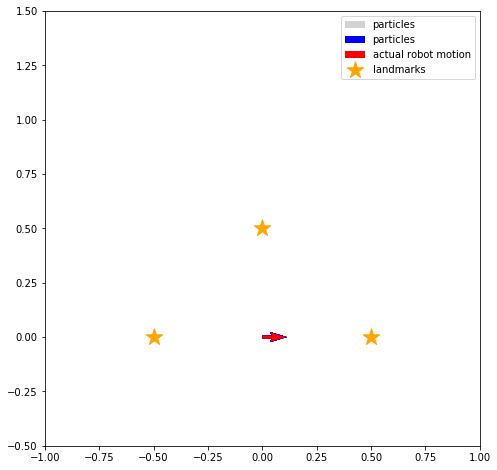

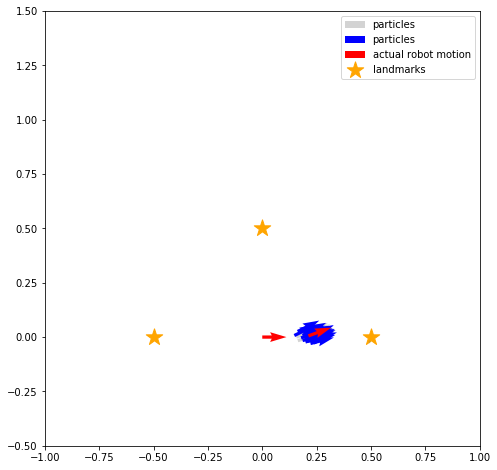

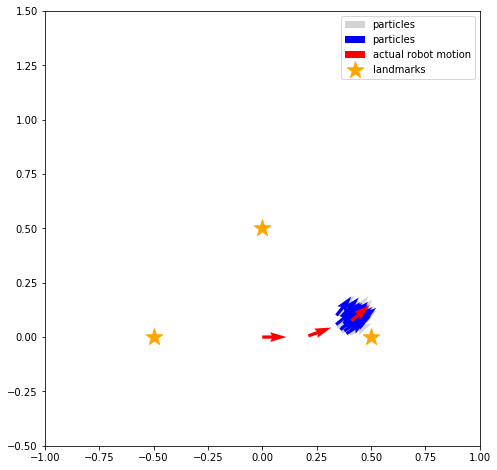

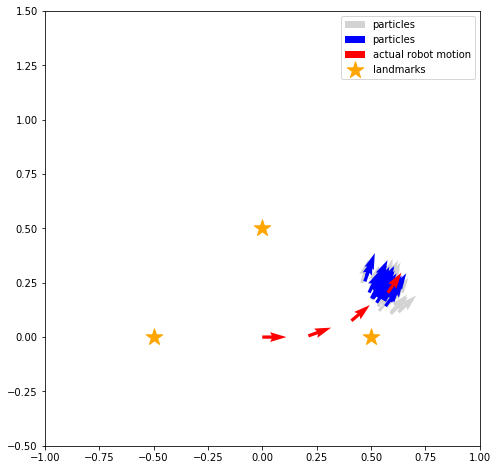

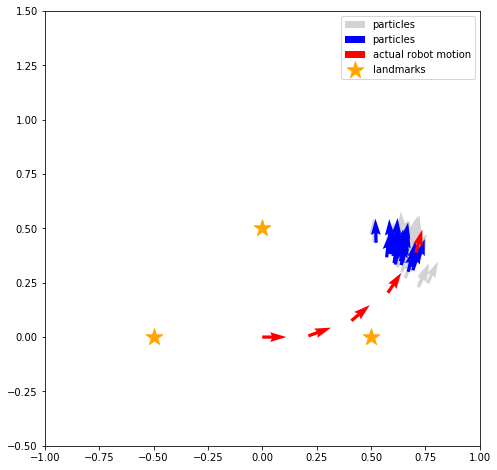

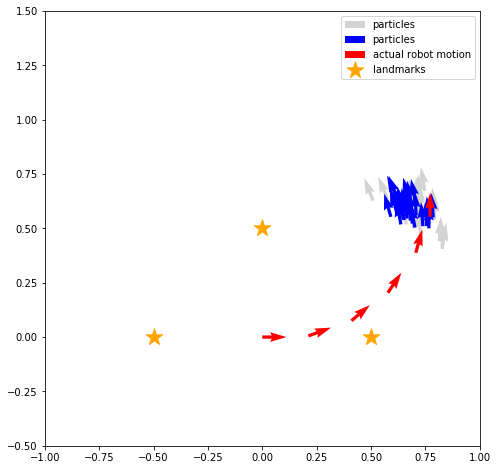

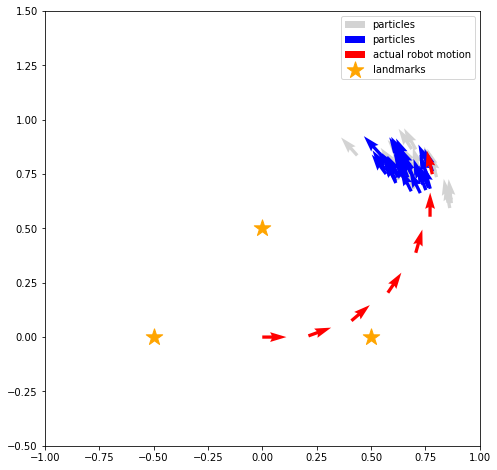

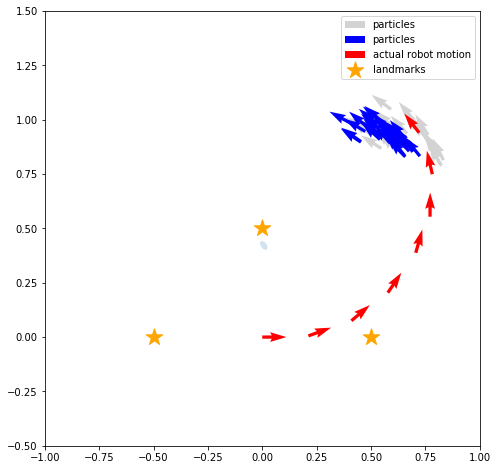

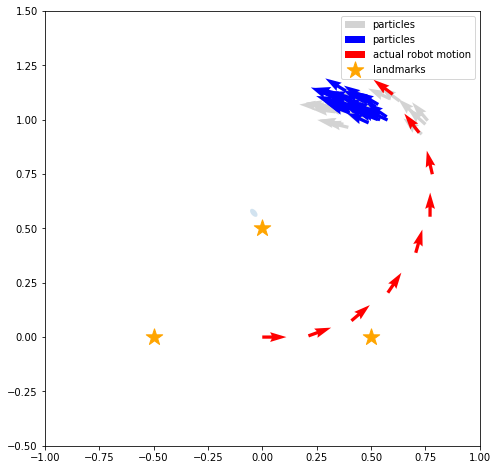

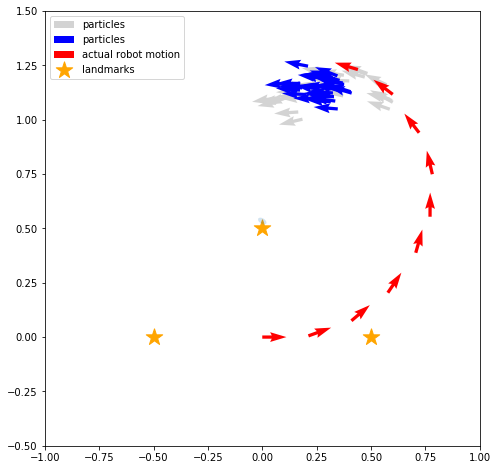

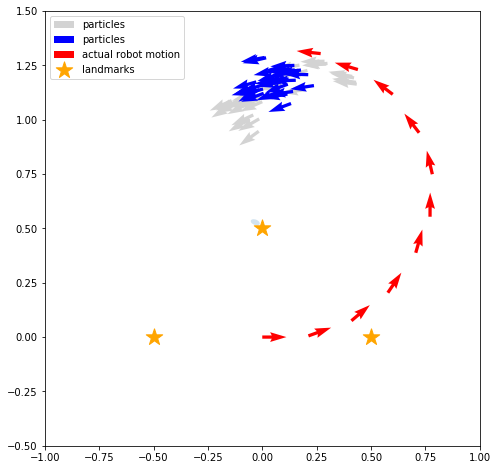

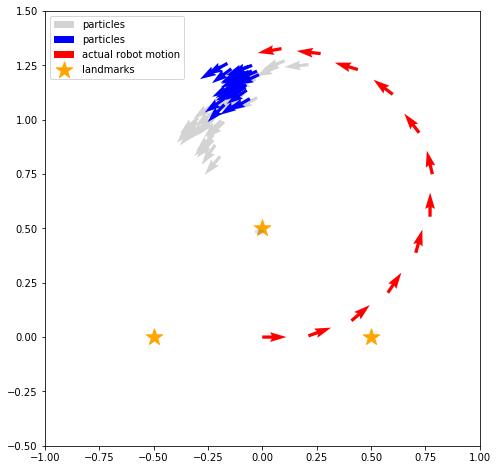

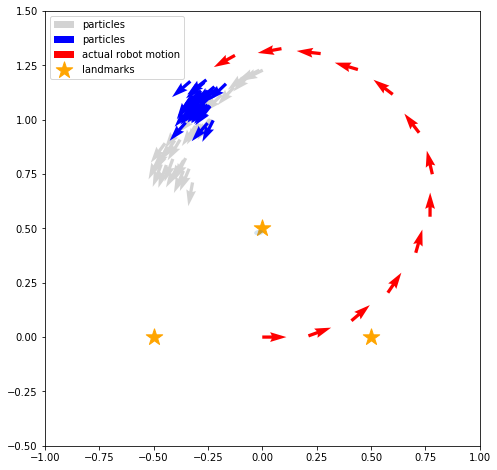

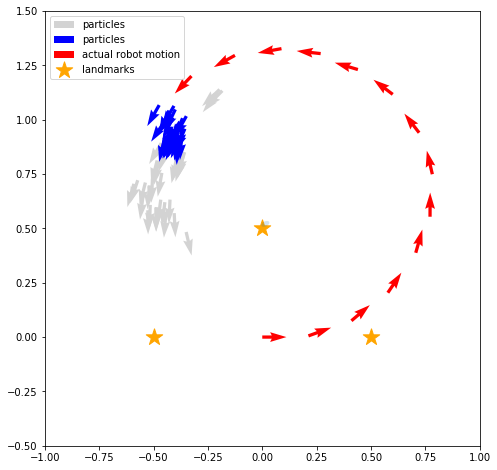

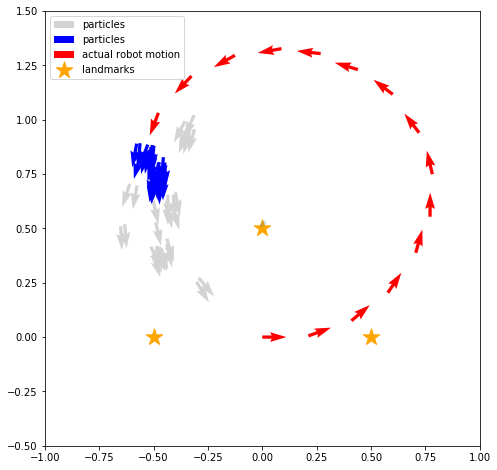

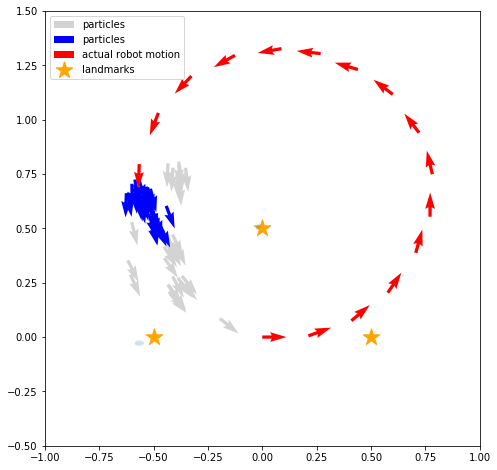

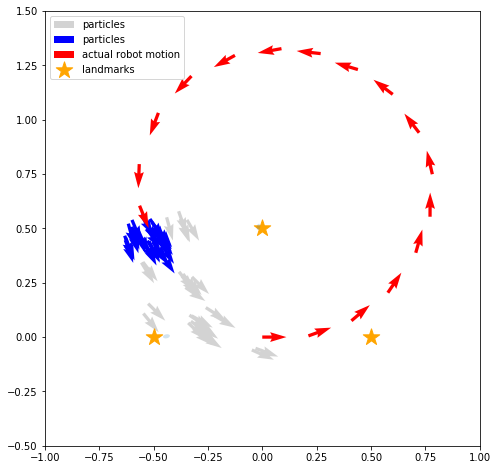

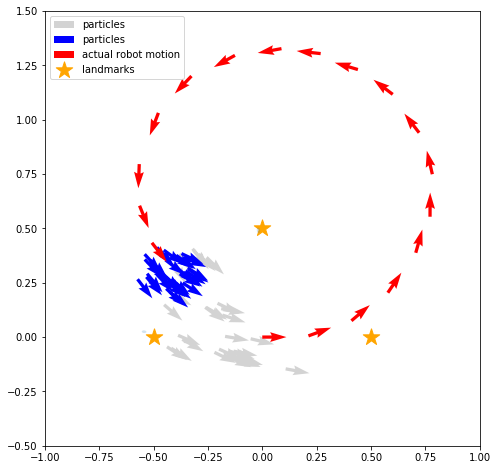

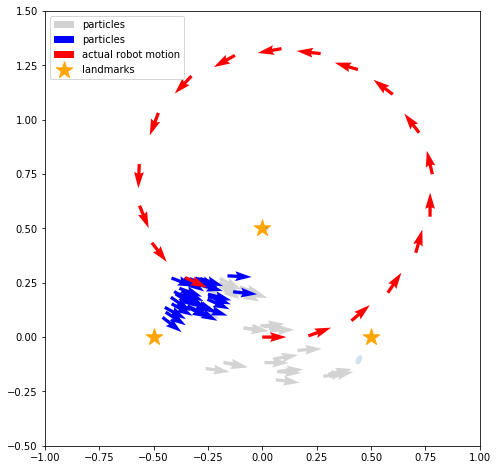

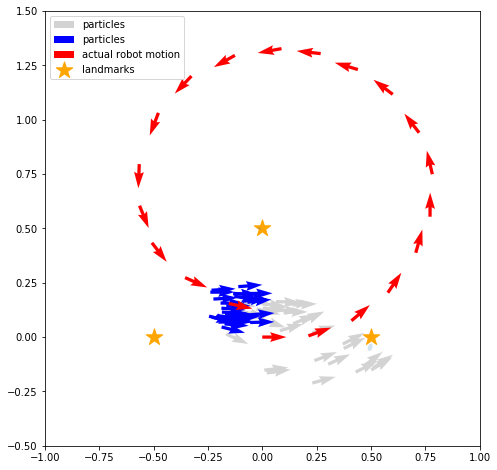

In [6]:
robot = Robot(0,0,0)
draw(0)

for i in range(1,20):
    robot.move(0.2,math.pi / 180.0 * 20)
    robot.observation(actual_landmarks)
    draw(i)